# Lab02_523H0164


## Import libraries and create some useful functions

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_with_id(image, title="Image", student_id="523H0164"):
    """
    Displays an image using Matplotlib with a student ID watermark.
    """
    img_to_show = image.copy()
    font_scale = max(image.shape[1] / 900.0, 0.5)
    thickness = max(int(font_scale * 2), 1)
    margin = int(image.shape[1] * 0.015)
    position = (margin, image.shape[0] - margin)
    font = cv2.FONT_HERSHEY_SIMPLEX
    roi_y_start = image.shape[0] - int(image.shape[0] * 0.1)
    roi_x_end = int(image.shape[1] * 0.25)
    corner_roi = image[roi_y_start:, :roi_x_end]

    if len(corner_roi.shape) == 3 and corner_roi.shape[2] == 3:
        gray_roi = cv2.cvtColor(corner_roi, cv2.COLOR_BGR2GRAY)
        mean_intensity = np.mean(gray_roi)
    else:
        mean_intensity = np.mean(corner_roi)

    text_color_bgr = (0, 0, 0) if mean_intensity > 127 else (255, 255, 255)
    cv2.putText(img_to_show, student_id, position, font, font_scale, text_color_bgr, thickness)

    if len(img_to_show.shape) == 3 and img_to_show.shape[2] == 3:
        img_to_display = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
        plt.imshow(img_to_display)
    else:
        plt.imshow(img_to_show, cmap='gray')

    plt.title(title)
    plt.axis('off')
    plt.show()

In [2]:
from IPython.display import Javascript
from google.colab.output import eval_js
import base64
import cv2
import numpy as np

def take_photo(filename='photo.jpg', quality=0.8):
  """
  A corrected function to use the webcam in Colab.
  It wraps the entire JS logic in a single call to prevent reference errors.
  """
  try:
    js_code = f'''
      (async () => {{
        const div = document.createElement('div');
        const video = document.createElement('video');
        video.style.display = 'block';
        const button = document.createElement('button');
        button.textContent = 'Take Photo';
        div.appendChild(button);
        div.appendChild(video);
        document.body.appendChild(div);
        const stream = await navigator.mediaDevices.getUserMedia({{video: true}});
        video.srcObject = stream;
        await video.play();
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => button.onclick = resolve);
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        document.body.removeChild(div);
        return canvas.toDataURL('image/jpeg', {quality});
      }})()
      '''

    data = eval_js(js_code)

    binary = base64.b64decode(data.split(',')[1])

    nparr = np.frombuffer(binary, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    cv2.imwrite(filename, img)

    print(f'Photo saved to {filename}')
    return img

  except Exception as err:
    print(f'Error taking photo: {str(err)}')
    return None

ModuleNotFoundError: No module named 'google'

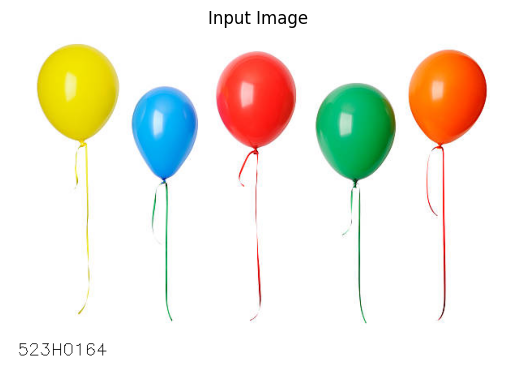

In [ ]:
# Load the image
try:
    img_balloons = cv2.imread('/content/five_balloons.png')
    if img_balloons is None:
        raise FileNotFoundError("Image not found.")
    display_with_id(img_balloons, "Input Image")
except FileNotFoundError as e:
    print(e)

## Exercise 1:
Split each color channel of the image

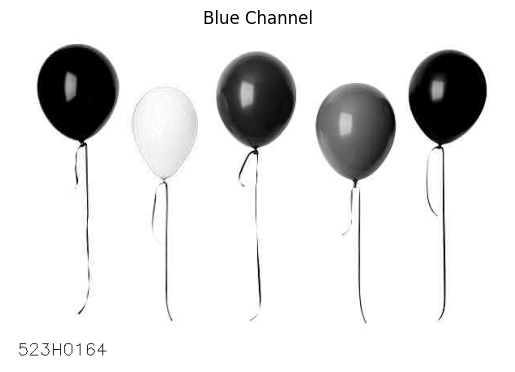

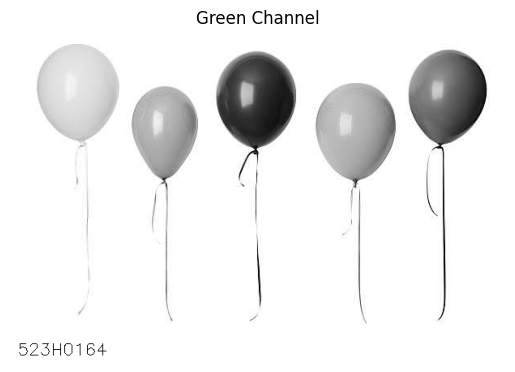

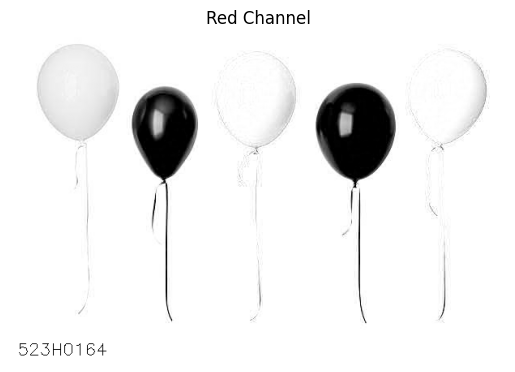

In [ ]:
b, g, r = cv2.split(img_balloons)
display_with_id(b, title="Blue Channel")
display_with_id(g, title="Green Channel")
display_with_id(r, title="Red Channel")

## Exercise 2 and 3:
- Locate the position of each balloon by drawing a rectangle  (bounding-box) surrounding each balloon

- Name each balloon by putting a text of color name right above the bounding boxes.

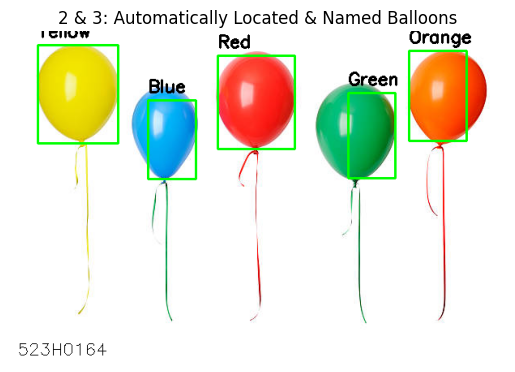

In [ ]:
def auto_detect_balloons(image):
    output_image = image.copy()
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    detected_data = {}

    color_ranges = {
        "Red": ([0, 150, 100], [10, 255, 255], [170, 150, 100], [180, 255, 255]),
        "Yellow": ([22, 120, 120], [30, 255, 255]),
        "Green": ([35, 100, 50], [75, 255, 255]),
        "Blue": ([100, 150, 50], [130, 255, 255]),
        "Orange": ([10, 150, 100], [20, 255, 255])
    }

    for color_name, bounds in color_ranges.items():
        lower1, upper1 = np.array(bounds[0]), np.array(bounds[1])
        mask = cv2.inRange(hsv_image, lower1, upper1)
        if color_name == "Red":
            mask += cv2.inRange(hsv_image, np.array(bounds[2]), np.array(bounds[3]))

        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            if cv2.contourArea(largest_contour) > 500:
                x, y, w, h = cv2.boundingRect(largest_contour)
                detected_data[color_name] = (x, y, w, h)
                cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(output_image, color_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    return output_image, detected_data

annotated_image, balloon_data = auto_detect_balloons(img_balloons)
display_with_id(annotated_image, title="2 & 3: Automatically Located & Named Balloons")

## Exercise 4:
Extract the yellow balloon by creating a new image of only one balloon.

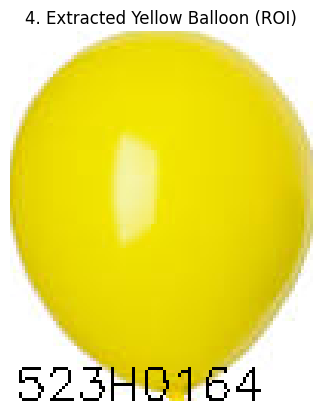

In [ ]:
x, y, w, h = balloon_data['Yellow']
yellow_roi = img_balloons[y:y+h, x:x+w]
display_with_id(yellow_roi, title="4. Extracted Yellow Balloon (ROI)")

## Exercise 5:
Extract the yellow balloon automatically by using HSV color space to extract only pixels of yellow color.

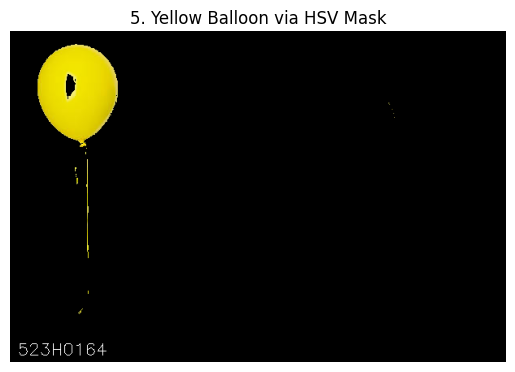

In [ ]:
hsv_image = cv2.cvtColor(img_balloons, cv2.COLOR_BGR2HSV)
lower_yellow = np.array([22, 120, 120])
upper_yellow = np.array([30, 255, 255])
mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
yellow_extracted = cv2.bitwise_and(img_balloons, img_balloons, mask=mask)
display_with_id(yellow_extracted, title="5. Yellow Balloon via HSV Mask")

## Exercise 6:
Re-paint the yellow balloon by replacing the pixels of yellow by green.

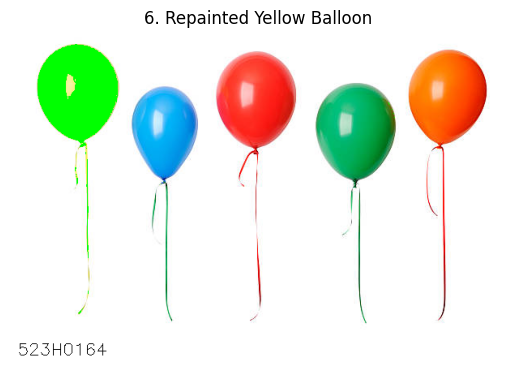

In [ ]:
img_repainted = img_balloons.copy()
img_repainted[mask != 0] = [0, 255, 0] # BGR for green
display_with_id(img_repainted, title="6. Repainted Yellow Balloon")

## Exercise 7:
Rotate the first balloon an angle of 20 degree

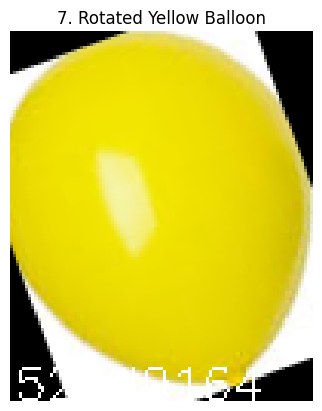

In [ ]:
(h, w) = yellow_roi.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, 20, 1.0)
rotated_balloon = cv2.warpAffine(yellow_roi, M, (w, h))
display_with_id(rotated_balloon, title="7. Rotated Yellow Balloon")

# Exercise 8:
Increase the brightness of the image

Please allow camera access and click the 'Take Photo' button.
Photo saved to photo.jpg

Photo captured. Applying enhancements.


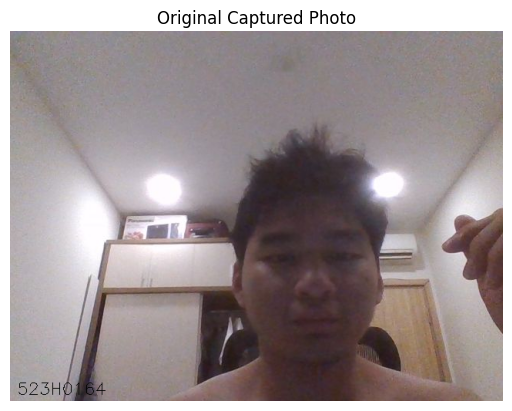

In [ ]:
# Open webcam to read an image of your face
print("Please allow camera access and click the 'Take Photo' button.")
frame_to_enhance = take_photo()

print("\nPhoto captured. Applying enhancements.")
display_with_id(frame_to_enhance, title="Original Captured Photo")

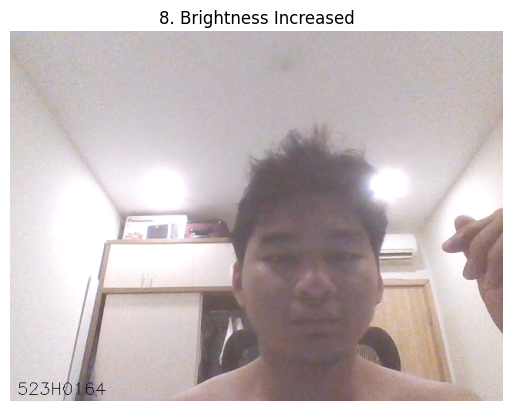

In [ ]:
brightened_image = cv2.add(frame_to_enhance, np.ones(frame_to_enhance.shape, dtype="uint8") * 50)
display_with_id(brightened_image, title="8. Brightness Increased")

## Exercise 9:
Enhance the image contrast by using global histogram equalization

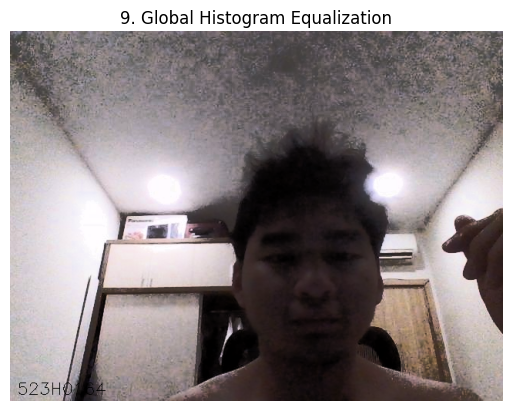

In [ ]:
hsv_image = cv2.cvtColor(frame_to_enhance, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_image)

v_global_eq = cv2.equalizeHist(v)
global_eq_image = cv2.cvtColor(cv2.merge([h, s, v_global_eq]), cv2.COLOR_HSV2BGR)
display_with_id(global_eq_image, title="9. Global Histogram Equalization")

## Exercise 10:
Enhance the image contrast by using adaptive histogram equalization (CLAHE)

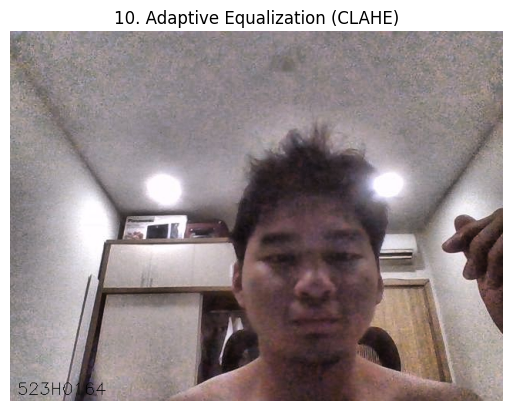

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
v_clahe_eq = clahe.apply(v)
clahe_image = cv2.cvtColor(cv2.merge([h, s, v_clahe_eq]), cv2.COLOR_HSV2BGR)
display_with_id(clahe_image, title="10. Adaptive Equalization (CLAHE)")

# Additional Exercises

## Exercise page 25

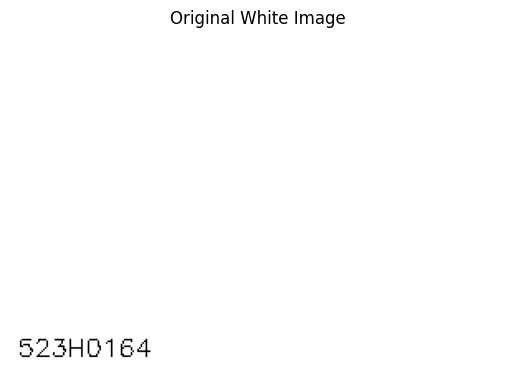

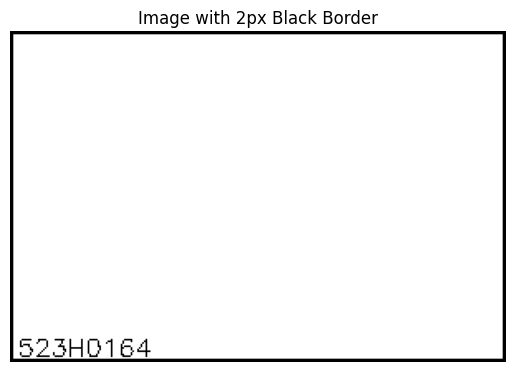

In [ ]:
white_image = np.full((200, 300), 255, dtype=np.uint8)
display_with_id(white_image, "Original White Image")
bordered_image = white_image.copy()
border_thickness = 2
bordered_image[0:border_thickness, :] = 0
bordered_image[-border_thickness:, :] = 0
bordered_image[:, 0:border_thickness] = 0
bordered_image[:, -border_thickness:] = 0
display_with_id(bordered_image, "Image with 2px Black Border")

## Exercise page 32

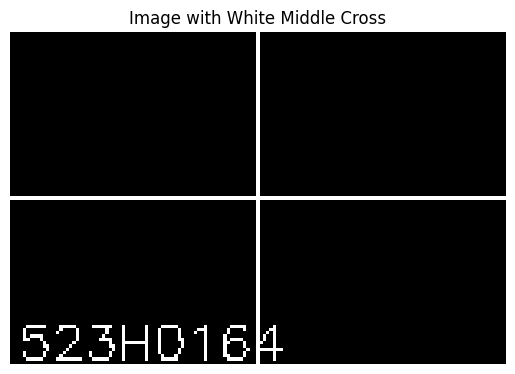

In [ ]:
black_image = np.zeros((101, 151), dtype=np.uint8)
M, N = black_image.shape
mid_row, mid_col = M // 2, N // 2
black_image[mid_row, :] = 255
black_image[:, mid_col] = 255
display_with_id(black_image, "Image with White Middle Cross")

## Exercise page 38

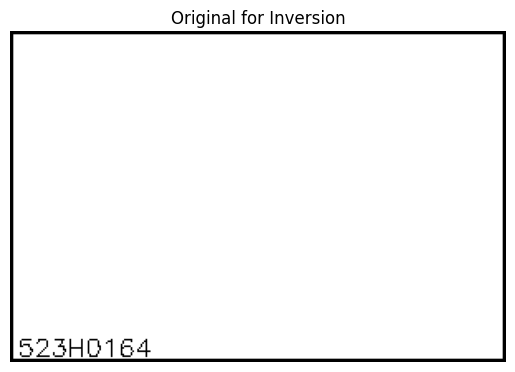

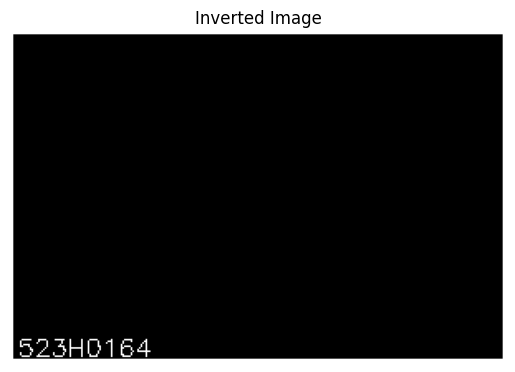

In [ ]:
# Using the bordered image from the first additional exercise
inverted_image = cv2.bitwise_not(bordered_image)
display_with_id(bordered_image, "Original for Inversion")
display_with_id(inverted_image, "Inverted Image")

## Exercise page 46

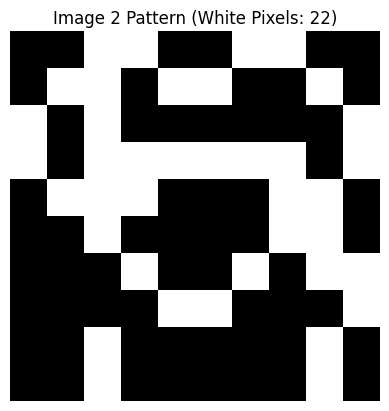

In [ ]:
paw_pattern = np.array([
    [0,0,1,1,0,0,1,1,0,0], [0,1,0,0,1,1,0,0,1,0],
    [1,0,0,0,0,0,0,0,0,1], [1,0,0,1,0,0,1,0,0,1],
    [0,1,0,0,0,0,0,0,1,0], [0,0,1,0,0,0,0,1,0,0],
    [0,0,0,1,0,0,1,0,0,0], [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0]
], dtype=np.uint8)
paw_image = paw_pattern * 255
white_pixel_count = np.count_nonzero(paw_image)
display_with_id(paw_image, f"Image 2 Pattern (White Pixels: {white_pixel_count})")

## Exercise page 48

The average intensity of the image is: 85.80


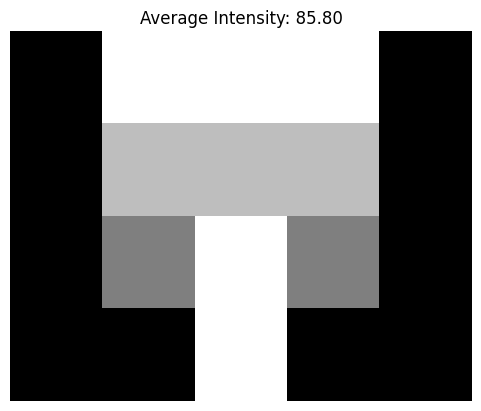

In [ ]:
grayscale_image = np.array([
    [0, 255, 255, 255, 0], [0, 190, 190, 190, 0],
    [0, 127, 127, 127, 0], [0, 0, 0, 0, 0]
], dtype=np.uint8)
average_intensity = np.mean(grayscale_image)
print(f"The average intensity of the image is: {average_intensity:.2f}")
display_with_id(grayscale_image, f"Average Intensity: {average_intensity:.2f}")